In [1]:
from models.utils.ARViT2D import ARViT2D
from models.utils.distance_loss import ARViT2D_Loss
from models.utils.metrics import Accuracy
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from fastai.distributed import *
from fastai.vision.all import *

from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import torchvision.transforms as T
import torch
from torchvision.transforms.functional import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import math
import logging
from functools import partial
from collections import OrderedDict
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F

from models.layers.layers import PatchEmbed, Mlp, trunc_normal_#, lecun_normal_
from models.layers.drop import DropPath

In [6]:
model = ARViT2D(num_encoder_layers = 6, nhead=12, num_classes = 4, mask=None, pos_enc = "sin", 
                batch_size=10, in_chans=3, hidden_dim=516, image_h=256, image_w=256, grid_l=16, 
                gm_patch = 32, use_patches=True, attn_layer = 1,penalty_factor="2", alpha=4, 
                beta=500, gamma=0.1).to(device)

In [7]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

10909800

In [8]:
H = 256
W= 256
bs = 10
gd = 16

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
])

In [9]:
path1 = untar_data(URLs.IMAGENETTE)
def data_loader(path):
    transform = ([*aug_transforms(),Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                     get_items=get_image_files, 
                     splitter=RandomSplitter(),
                     get_y=parent_label,
                     item_tfms=Resize(H,W),
                     batch_tfms=transform)

    dloader = data.dataloaders(path,bs=bs)
    return dloader
dloader =  data_loader(path1)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
im = Image.open('sample_images/image'+str(10)+'.jpeg')
img = transform(im).unsqueeze(0).to(device)
outputs, attn, sattn, pm  = model(img.to(device))

(-0.5, 255.5, 255.5, -0.5)

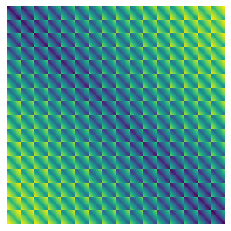

In [12]:
# plt.subplot(221)
# plt.imshow(pm[0].cpu().detach().numpy())#[136].reshape(16,16))
plt.plot()
plt.imshow(pm[0].cpu().detach().numpy(),cmap='viridis', interpolation='nearest')
plt.axis('off')

In [23]:
ARViT_Loss = ARViT2D_Loss(layer=1)

In [24]:
learner = Learner(dloader, model, loss_func=ARViT_Loss, metrics=[Accuracy])

SuggestedLRs(lr_min=6.30957365501672e-06, lr_steep=6.309573450380412e-07)

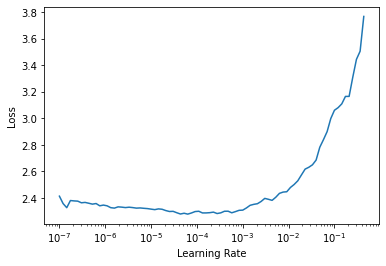

In [10]:
learner.lr_find()

In [26]:
model_dir = Path.home()/'Luiz/saved_models/AROB'
file_name = 'ARViT2D-12L'
learner.export(model_dir/file_name)